In [1]:
%matplotlib notebook
import os
import pandas as pd
import numpy as np
import lightkurve as lk
from del_scu_search import Periodogram
from del_scu_search import SinModel,PM_Model
import matplotlib.pyplot as plt
from ptv_search import *

Create a function to create fake periodogram data based on the base function:
$$sin(2\pi f (t + \phi))$$
where $\phi$ is a constant for now

<IPython.core.display.Javascript object>


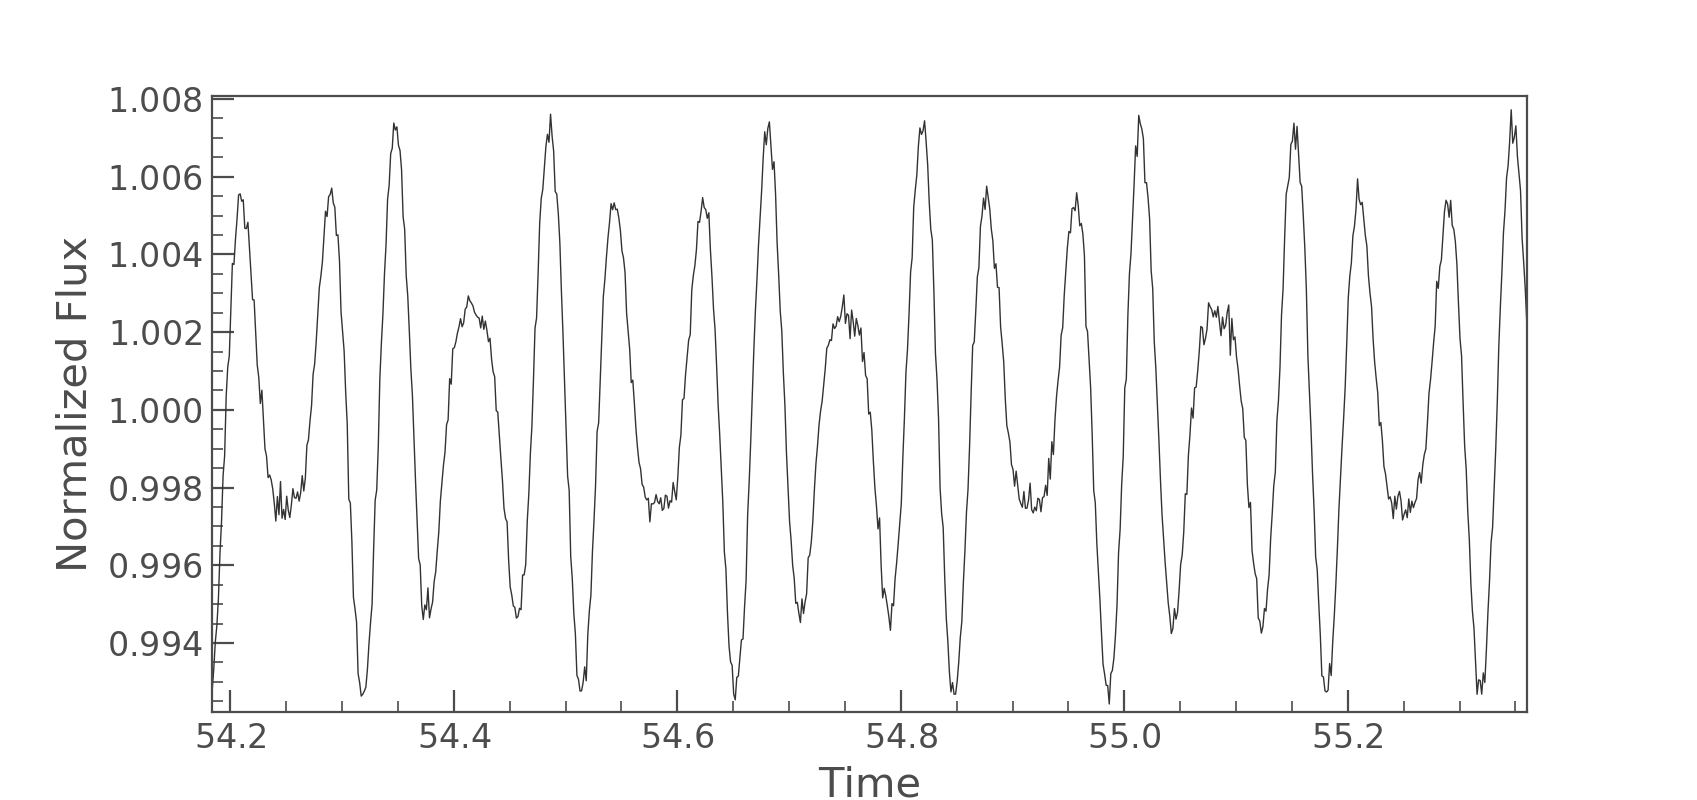

In [2]:
baseline = 185 # in days
cadence = 2 # in minutes

freq1 = 15 #cycles per day
amp1 = 0.01

freq2 = 21 #cycles per day
amp2  = 0.005

time = np.linspace(0,baseline,(baseline*24*60)//cadence)

sinmodel1 = SinModel(time,freq1,0,amp1)
sinmodel2 = SinModel(time,freq2,25,amp2)

sinmodel = sinmodel1 + sinmodel2

flux = sinmodel.add_noise_model(0.0005)

lc = lk.LightCurve(time=time,flux=flux)
lc.plot()

Now use a more complicated model to create a fake lightcurve for a Delta Scuti:

$$sin(t + \phi(t))$$ where $$\phi(t)=A_{planet}*sin\left( \frac{2\pi(t + \phi_{planet})}{P_{planet}}\right)$$ is a time varying sinusoidal function

[20] [0.01] [0] [1.         1.00173649 1.00342021 ... 0.99657979 0.99826351 1.        ]
[23] [0.003] [10] [1.         1.00059811 1.0011722  ... 0.9988278  0.99940189 1.        ]
[20, 23] [0.01, 0.003] [0, 10] [2.         2.00233459 2.00459241 ... 1.99540759 1.99766541 2.        ]


<IPython.core.display.Javascript object>


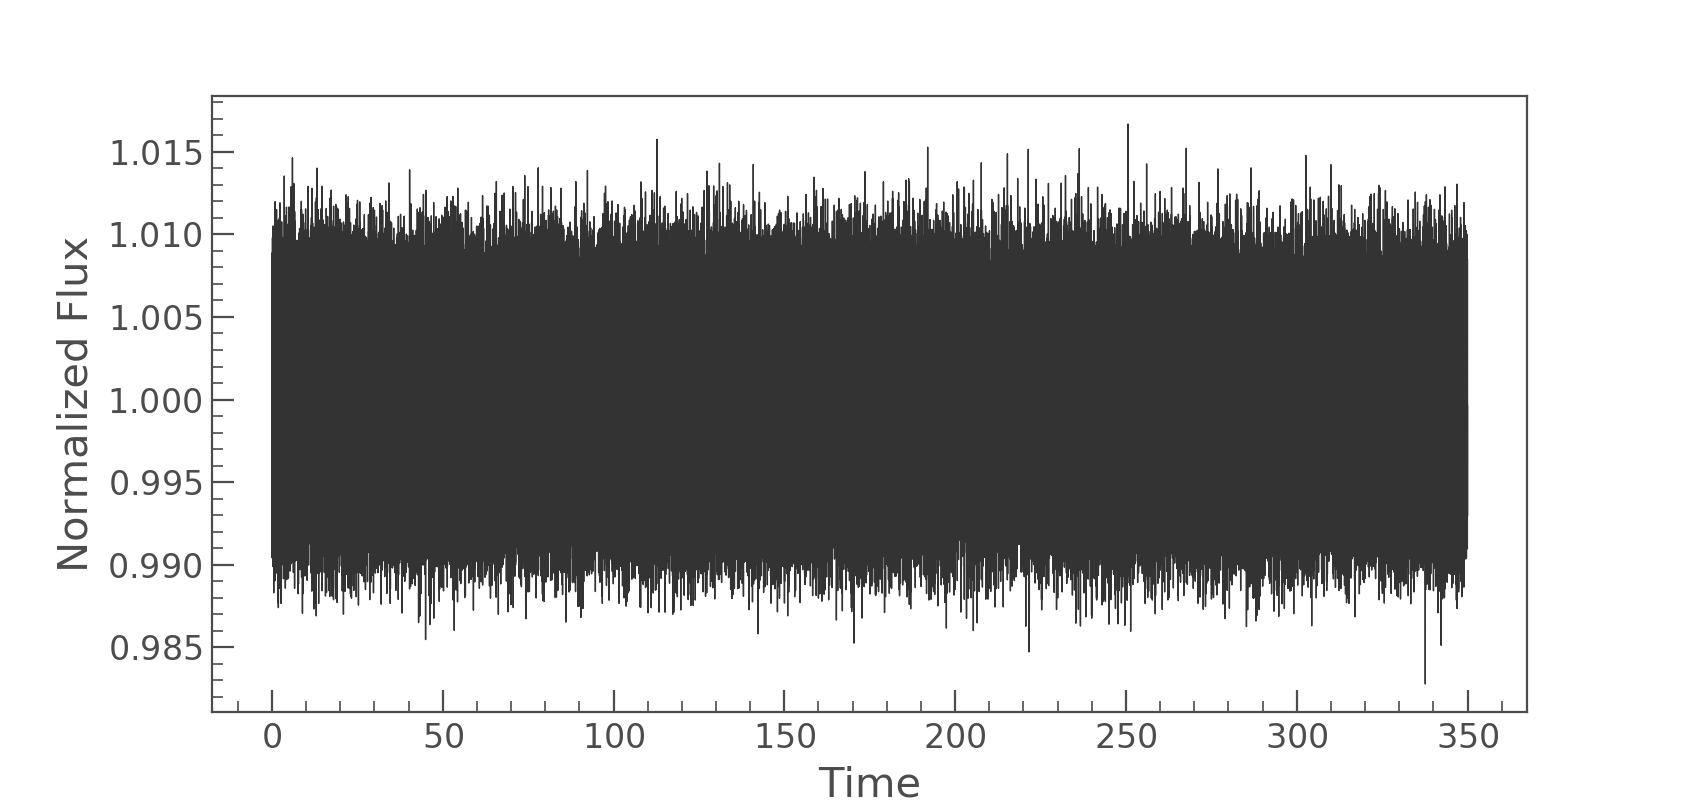

In [3]:
baseline = 350 # in days
cadence = 2 # in minutes

freq1 = 20 #cycles per day
amp1 = 0.01

freq2 = 23 #cycles per day
amp2 = 0.003
time = np.linspace(0,baseline,(baseline*24*60)//cadence)

period_ptv = 840
phase_ptv = 0
amp_ptv = 1 #seconds
pmmodel1 = PM_Model(time,freq1,0,amp1,period_ptv,phase_ptv,amp_ptv/(24*60*60))
pmmodel2 = PM_Model(time,freq2,10,amp2,period_ptv,phase_ptv,amp_ptv/(24*60*60))
pmmodel = pmmodel1+pmmodel2
flux = pmmodel.add_noise_model(0.005)

lc = lk.LightCurve(time=time,flux=flux)
lc.plot()

In [ ]:
ticid = 'FAKE'
lc = lc.remove_nans()
ax = lc.plot()
ax.figure.savefig('lightcurves/'+str(ticid)+'_lc.png')
plt.close()

periodogram = Periodogram(lc)
del_scu = periodogram.is_delta_scuti()
plt.plot(periodogram.frequency,periodogram.power)
print(del_scu)
if del_scu:
    frequency,power,peaks = periodogram.frequency, periodogram.power,periodogram.peaks
    peak_freqs = frequency[peaks]
    pg = lc.to_periodogram(min_frequency = peak_freqs[0]-0.3,max_frequency = peak_freqs[0]+0.3, oversample_factor = 500, nyquist_factor = 4)
    freqs = [pg.frequency_at_max_power.value]
    print(pg.frequency_at_max_power.value)

    plt.clf()
    plt.plot(frequency,power,c='blue')
    plt.scatter(frequency[peaks],power[peaks],c='black')
    discard_peaks = periodogram.get_discard_peaks()
    plt.scatter(frequency[discard_peaks],power[discard_peaks],c='red')

    plt.xlabel('Frequency (cycles/day)')
    plt.ylabel('Power')
    plt.xlim([0,40])
    plt.savefig('periodograms/'+str(ticid)+'_pg.png')
    plt.close()

    periodlist, mediantimelist = find_phase_OC(lc,freqs)
    plot_LAT('o-c plots/'+str(ticid)+'_o_c.png', mediantimelist, periodlist)